Notebook by Philippe Sayegh 260637812 based on the 

In [ ]:
! pip install pettingzoo==1.22.3
! pip install pymunk
! pip install multi_agent_ale_py
! pip install "autorom[accept-rom-license]"

! apt-get install -y xvfb

In [ ]:
! AutoROM --accept-license

In [ ]:
#imports
import time
import numpy as np
import cv2


from pettingzoo import AECEnv
from pettingzoo.atari import space_invaders_v2
from typing import Any, Dict, List, Tuple, Optional
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook

import torch
import os
from torch.nn.functional import normalize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Q-learning with LFA and epsilon-greedy

In [ ]:
# Setup

#To use random baseline
RANDOM_BOTH = False
#To use Q-learning with LFA and epsilon-greedy policy
QL_BOTH = True

px_per_img = 160*210
use_rgb  = True

runs = 2
episodes = 100
action_padding = 16800
epsilon = 0.9
gamma = 0.99
lr = 0.01
incr_clip = 1

start_lr = lr

num_steps_per_ep = np.zeros(episodes)

rewards_per_run_ep = np.zeros((episodes, runs))
rewards_per_run_ep_disc = np.zeros((episodes, runs))

rewards_eps_mean = np.zeros((episodes))
rewards_eps_mean_disc = np.zeros((episodes))

rewards_eps_std_err = np.zeros((episodes))
rewards_eps_std_err_disc = np.zeros((episodes))

if use_rgb:
  px_per_img *= 3


In [ ]:
# Transform rgb np array to grayscale

def rgb_to_gray(rgb_image):
    r, g, b = rgb_image[:, :, 0], rgb_image[:, :, 1], rgb_image[:, :, 2]
    gray_image = 0.2989 * r + 0.5870 * g + 0.1140 * b
    gray_image = np.round(gray_image).astype(np.uint8)
    return gray_image

In [ ]:
# Implement epsilon greedy policy
def epsilon_greedy(cs, w, agent_name, env, epsilon, action_padding):

  if not use_rgb:
    cs = rgb_to_gray(cs.get(agent_name))
  else:
    cs = cs.get(agent_name)
  cs = torch.tensor(cs.flatten()).to(device)
  
  # Choose action using epsilon greedy policy
  threshold = np.random.rand()
  if 1.0-epsilon > threshold:

    action = int(np.floor(np.random.rand() * 6))
    #build feature vector with action
    x_csa = torch.zeros(px_per_img+action_padding).to(device)
    x_csa[:px_per_img] = cs
    x_csa[px_per_img:] = torch.ones(action_padding).to(device) * action
    q_csa = torch.dot(w, x_csa)
    
  else:

    # Compute the Q value of all 6 possible actions at this state

    x_cs0 = torch.zeros(px_per_img+action_padding, device=device)
    x_cs1 = torch.zeros(px_per_img+action_padding, device=device)
    x_cs2 = torch.zeros(px_per_img+action_padding, device=device)
    x_cs3 = torch.zeros(px_per_img+action_padding, device=device)
    x_cs4 = torch.zeros(px_per_img+action_padding, device=device)
    x_cs5 = torch.zeros(px_per_img+action_padding, device=device)

    x_cs0[:px_per_img] = cs
    x_cs1[:px_per_img] = cs
    x_cs2[:px_per_img] = cs
    x_cs3[:px_per_img] = cs
    x_cs4[:px_per_img] = cs
    x_cs5[:px_per_img] = cs

    x_cs0[px_per_img:] = torch.ones(action_padding, device=device) * 0 * 51
    x_cs1[px_per_img:] = torch.ones(action_padding, device=device) * 1 * 51
    x_cs2[px_per_img:] = torch.ones(action_padding, device=device) * 2 * 51
    x_cs3[px_per_img:] = torch.ones(action_padding, device=device) * 3 * 51
    x_cs4[px_per_img:] = torch.ones(action_padding, device=device) * 4 * 51
    x_cs5[px_per_img:] = torch.ones(action_padding, device=device) * 5 * 51

    x_cs0 = normalize(x_cs0, dim=0)
    x_cs1 = normalize(x_cs1, dim=0)
    x_cs2 = normalize(x_cs2, dim=0)
    x_cs3 = normalize(x_cs3, dim=0)
    x_cs4 = normalize(x_cs4, dim=0)
    x_cs5 = normalize(x_cs5, dim=0)

    xs = torch.stack([x_cs0, x_cs1, x_cs2, x_cs3, x_cs4, x_cs5])

    # Compute Q-values
    q_vals = torch.matmul(xs, w)

    q_vals = q_vals.cpu()


    # Choose best action
    max_idx = torch.argmax(q_vals)

    q_csa = q_vals[max_idx]
    x_csa = xs[max_idx]
    action = max_idx.item()


  return (q_csa, x_csa, action)

In [ ]:
# This function performs Q-learning with LFA for a single agent
def ql_lfa(w, ns, agent_name, q_csa, x_csa, r, alpha, gamma, action_padding):

  if not use_rgb:
    ns = rgb_to_gray(ns.get(agent_name))
  else:
    ns = ns.get(agent_name)
  ns = torch.tensor(ns.flatten()).to(device)

  # Find the action at the next state that yields the highest Q value

  x_ns0 = torch.zeros(px_per_img+action_padding, device=device)
  x_ns1 = torch.zeros(px_per_img+action_padding, device=device)
  x_ns2 = torch.zeros(px_per_img+action_padding, device=device)
  x_ns3 = torch.zeros(px_per_img+action_padding, device=device)
  x_ns4 = torch.zeros(px_per_img+action_padding, device=device)
  x_ns5 = torch.zeros(px_per_img+action_padding, device=device)

  x_ns0[:px_per_img] = ns
  x_ns1[:px_per_img] = ns
  x_ns2[:px_per_img] = ns
  x_ns3[:px_per_img] = ns
  x_ns4[:px_per_img] = ns
  x_ns5[:px_per_img] = ns

  x_ns0[px_per_img:] = torch.ones(action_padding, device=device) * 0 * 51
  x_ns1[px_per_img:] = torch.ones(action_padding, device=device) * 1 * 51
  x_ns2[px_per_img:] = torch.ones(action_padding, device=device) * 2 * 51
  x_ns3[px_per_img:] = torch.ones(action_padding, device=device) * 3 * 51
  x_ns4[px_per_img:] = torch.ones(action_padding, device=device) * 4 * 51
  x_ns5[px_per_img:] = torch.ones(action_padding, device=device) * 5 * 51

  x_ns0 = normalize(x_ns0, dim=0)
  x_ns1 = normalize(x_ns1, dim=0)
  x_ns2 = normalize(x_ns2, dim=0)
  x_ns3 = normalize(x_ns3, dim=0)
  x_ns4 = normalize(x_ns4, dim=0)
  x_ns5 = normalize(x_ns5, dim=0)

  xs = torch.stack([x_ns0, x_ns1, x_ns2, x_ns3, x_ns4, x_ns5])

  # Compute Q-values
  q_vals = torch.matmul(xs, w)
  

  # Save it for the update step
  max_idx = torch.argmax(q_vals)

  q_nsa = q_vals[max_idx]
  x_nsa = xs[max_idx]

  
  # Update Q(s, action) implicitly through updating its weights
  delta = r + gamma * q_nsa - q_csa
  w = w + torch.clip(alpha * delta * x_csa, -incr_clip, incr_clip)

  return w

In [ ]:
# Main loop

env = space_invaders_v2.parallel_env(render_mode="rgb_array")


TRAIN = True
record_video = False
video_prefix = "no_learn_run"

if TRAIN:
  w1 = 0
  w2 = 0

for run in range(runs):
  #Init weight vectors for both agents
  if TRAIN:
    w1 = torch.from_numpy(np.random.uniform(low=-0.001, high=0.001, size=(px_per_img+action_padding))).to(torch.float).to(device)
    w2 = torch.from_numpy(np.random.uniform(low=-0.001, high=0.001, size=(px_per_img+action_padding))).to(torch.float).to(device)
  for ep in tqdm_notebook(range(episodes)):
    
    obs = env.reset()
    # Reset reward accumulators
    rewards_ep_acc = 0
    rewards_ep_acc_disc = 0
    game_steps = 0  

    # Video recording init code
    video_writer = None
    if record_video and ep % 100 == 0:
        video_path = os.path.join(os.getcwd(), f"{video_prefix}_q_lfa_epsilon_episode_{ep}_gamma_{gamma}.mp4")
        print(f"Recording video to {video_path}")
        frame_size = (160, 210)  # (width, height)
        video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'MP4V'), env.metadata["render_fps"], frame_size)

    # Main game loop running until termination or truncation of all agents
    while env.agents:
      # If we're running an uniform random policy
      if RANDOM_BOTH == True:
        actions = {agent: env.action_space(agent).sample() for agent in env.agents}
        obs, rewards, terminations, truncations, infos = env.step(actions)
      # If we're running a Q-learning policy for both agents
      if QL_BOTH == True:
        # Choose actions
        (q_csa_1, x_csa_1, action_1) = epsilon_greedy(obs, w1, "first_0", env, epsilon, action_padding)      
        (q_csa_2, x_csa_2, action_2) = epsilon_greedy(obs, w2, "second_0", env, epsilon, action_padding)
        actions = {"first_0": action_1, "second_0": action_2}
        # Take actions
        obs, rewards, terminations, truncations, infos = env.step(actions)
        if TRAIN:
          # Update weights
          w1 = ql_lfa(w1, obs, "first_0",  q_csa_1, x_csa_1, rewards.get("first_0"), lr, gamma, action_padding)
          w2 = ql_lfa(w2, obs, "second_0", q_csa_2, x_csa_2, rewards.get("second_0"), lr, gamma, action_padding)
      
      
      # Accumulate the rewards for this episode and run throughout the moves
      rewards_ep_acc += rewards.get('first_0') + rewards.get('second_0')
      rewards_ep_acc_disc += rewards.get('first_0') + rewards.get('second_0') * (0.999 ** game_steps)

      # Video recording code
      if record_video:
        frame = env.render()
        if record_video and ep % 100 == 0 and video_writer is not None:
            video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # Convert to BGR format

      # Count steps for this game playthrough
      game_steps += 1
    num_steps_per_ep[ep] = game_steps

    # Save accumulated rewards for this episode and run
    rewards_per_run_ep[ep][run] = rewards_ep_acc
    rewards_per_run_ep_disc[ep][run] = rewards_ep_acc_disc
    # Decay LR
    if ep%10 == 0:
      lr *= 0.1
    if video_writer is not None:    
        video_writer.release()

    
# Compute performance metrics
rewards_eps_mean = np.mean(rewards_per_run_ep, axis=1)
rewards_eps_mean_disc = np.mean(rewards_per_run_ep_disc, axis=1)
rewards_eps_std_err = np.std(rewards_per_run_ep, axis=1) / np.sqrt(runs) 
rewards_eps_std_err_disc = np.std(rewards_per_run_ep_disc, axis=1) / np.sqrt(runs) 

env.close()


  0%|          | 0/100 [00:00<?, ?it/s]

## Results

In [ ]:
# Save some results for the report

ep_total_rewards = rewards_per_run_ep[:, 0]
ep_total_rewards_discounted = rewards_per_run_ep_disc[:, 0]

q_lfa_results = np.array([ep_total_rewards, ep_total_rewards_discounted, num_steps_per_ep])

np.save('q_lfa_results.npy', q_lfa_results)

Text(0, 0.5, 'Reward')

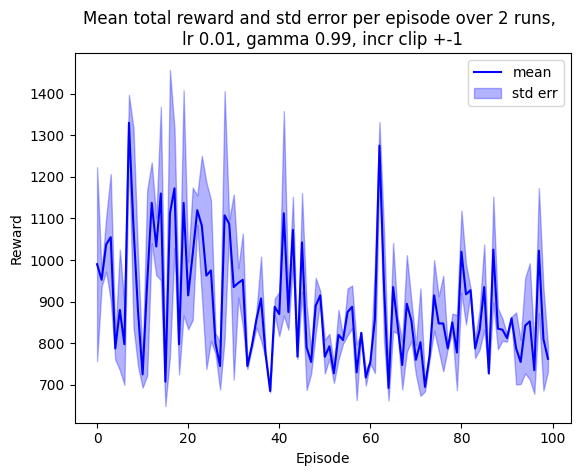

In [ ]:
# Build non-discounted mean reward plot
ig, ax = plt.subplots()
ax.plot(rewards_eps_mean, color='blue', label="mean")
plt.fill_between(range(len(rewards_eps_mean)),
                 rewards_eps_mean - rewards_eps_std_err,
                 rewards_eps_mean + rewards_eps_std_err,
                 alpha=0.3, color='blue', label="std err")

plt.title(f"Mean total reward and std error per episode over {runs} runs, \nlr {start_lr}, gamma {gamma}, incr clip +-{incr_clip}")
plt.legend(loc='upper right')

plt.xlabel("Episode")
plt.ylabel("Reward")


Text(0, 0.5, 'Discounted Reward')

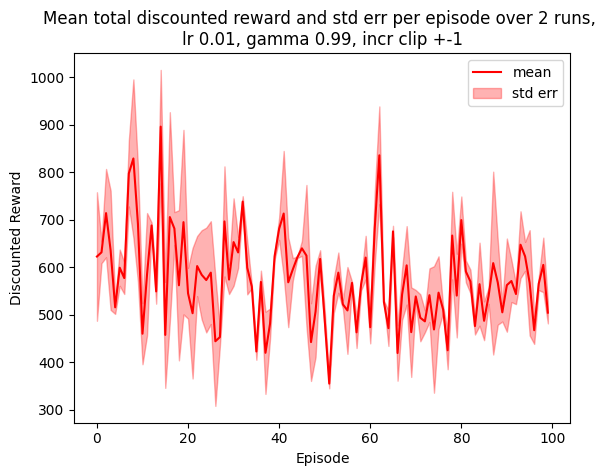

In [ ]:
# Build discounted mean reward plot
ig, ax = plt.subplots()
ax.plot(rewards_eps_mean_disc, color='red', label="mean")

plt.fill_between(range(len(rewards_eps_mean_disc)),
                 rewards_eps_mean_disc - rewards_eps_std_err_disc,
                 rewards_eps_mean_disc + rewards_eps_std_err_disc,
                 alpha=0.3, color='red', label="std err")

plt.title(f"Mean total discounted reward and std err per episode over {runs} runs, \nlr {start_lr}, gamma {gamma}, incr clip +-{incr_clip}")
plt.legend(loc='upper right')

plt.xlabel("Episode")
plt.ylabel("Discounted Reward")


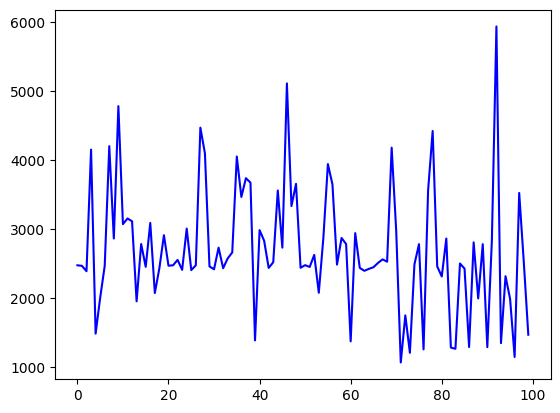

In [ ]:
# Build the number of steps per episode graph
ig, ax = plt.subplots()
ax.plot(num_steps_per_ep, color='blue')